# Convolutional Neural Networks

* When there is a need of processing and  understanding spatial information FC Layers generally fail
* In such use cases we typically use CNNs
* Lets look at a simple visualization https://github.com/vdumoulin/

* This is what really happens with multiple filters and channels in a CNN

<p align="center">
<img src="./doc_imgs/cnn.png" width="" height="400" />
</p>

* Each filter ideally captures a different feature representation of the image

* Where the ouptut height and width is determined by the following formula:
$$
H_{out} = \frac{H_{in} + 2 \times \text{padding}[0] - \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1

\\[0.25in]



W_{out} = \frac{W_{in} + 2 \times \text{padding}[1] - \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1

$$



## Implementation in PyTorch

In [36]:
# The necessary imports

import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch import optim
from torchvision import datasets, transforms, models, utils
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import TQDMProgressBar

import einops


# Here we dfine a module that can that can be reused/stacked
# according to our desired output channels/filters
class ConvLayer(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            kernel_size= (3,3),
            activationFn = nn.ReLU(),
            padding= 0):

        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    padding=padding,
                    kernel_size=kernel_size
                ),

                activationFn,
                nn.MaxPool2d(2,2)
        )

    def forward(self, x):
        return self.cnn(x)

## Stacking the above defined layers to build a simple CNN

In [37]:
class simpleCNN(nn.Module):
    def __init__(self, filters= [3, 6, 16], num_classes= 10):
        super().__init__()

        self.cnn = nn.Sequential()
        
        for f in range(len(filters) - 1):
            self.cnn.append(ConvLayer(in_channels= filters[f], out_channels= filters[f+1], padding= 1))
        
        self.final = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(num_classes)
            )

    def forward(self, x, disp=False):
        in_x = x.detach()
        for c in self.cnn:
            x = c(x)
            if disp==True:
                print("Input Size: ", in_x.size(), " Output Size: ", x.size())
                in_x = x.detach()
        
        x = einops.rearrange(x, 'b c h w -> b (c h w)')
        x = self.final(x)
        return(x)

# Lets check the output with a randomly defined tensor
# recall that the input shape must satisfy NCHW tensor format

t = torch.randn(1,3,28,28) # Random tensor in NCHW format
model = simpleCNN() #instantiate model object

out = model(t, disp=True) # Forward Pass
out.size() #print shape of processed tensor

Input Size:  torch.Size([1, 3, 28, 28])  Output Size:  torch.Size([1, 6, 14, 14])
Input Size:  torch.Size([1, 6, 14, 14])  Output Size:  torch.Size([1, 16, 7, 7])


torch.Size([1, 10])

**Define the PL Trainer Class**

In [38]:

dataset_path = '/home/ibrahim/Projects/Datasets'

pl.seed_everything(42) # Use this to reproduce same results everytime
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

class CNN(pl.LightningModule):
    def __init__(self, model, num_classes= 10):
        super().__init__()

        self.train_bs = 64 
        self.val_bs  = 16

        self.loss  = nn.CrossEntropyLoss()
        self.model = model(num_classes= num_classes)
        self.acc   = torchmetrics.Accuracy()

        self.transform = transforms.Compose(
                            [transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                            )


    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self, lr = 1e-3):
        return optim.Adam(self.parameters(), lr = lr)

    def training_step(self, batch, batch_idx):
        x, y = batch
        out_logits = self.model(x)
        loss = self.loss(out_logits, y)

        train_acc  = self.acc(out_logits, y)

        # self.log("train_loss", loss, prog_bar=True, on_epoch= True)
        self.log("train_acc", train_acc, prog_bar=True, on_epoch= True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out_logits = self.model(x)
        
        # loss = self.loss(out_logits, y)
        val_acc = self.acc(out_logits, y)

        self.log("val_acc", val_acc, prog_bar=True, on_epoch=True)

    def train_dataloader(self):
        trainset = datasets.CIFAR10(root= dataset_path, train=True,
                                        download=True, transform=self.transform)

        train_loader = DataLoader(trainset, batch_size=self.train_bs,
                                                shuffle=True, num_workers=4)

        return train_loader

    def val_dataloader(self):
        val_set = datasets.CIFAR10(root= dataset_path, train=True,
                                        download=True, transform=self.transform)
        val_loader = DataLoader(val_set, batch_size=self.val_bs,
                                                shuffle=False, num_workers=4)

        return val_loader

Global seed set to 42


**Lets look at the dataset**


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


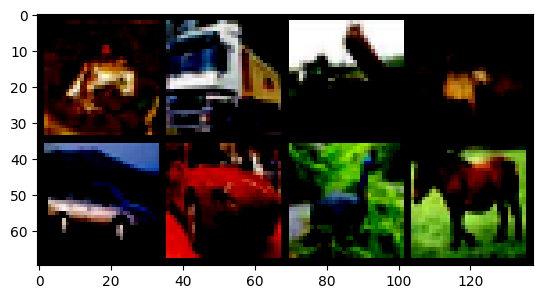

tensor([6, 9, 9, 4, 1, 1, 2, 7])

In [39]:
model = CNN(model= simpleCNN)
loader = model.val_dataloader()
batch = next(iter(loader))
batch[0].size(), batch[1].size()

grid_image = utils.make_grid(batch[0][0:8], nrow=4)
plt.imshow(grid_image.permute(1,2,0))
plt.show()


# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
batch[1][0:8]



In [40]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=2,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    enable_checkpointing= False,
    logger= False
)

trainer.fit(model)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | simpleCNN        | 1.0 K 
2 | acc   | Accuracy         | 0     
-------------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]Files already downloaded and verified
Files already downloaded and verified                                      
Epoch 1: 100%|██████████| 3907/3907 [00:10<00:00, 372.43it/s, loss=1.26, train_acc_step=0.562, val_acc=0.583, train_acc_epoch=0.558]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 3907/3907 [00:10<00:00, 372.40it/s, loss=1.26, train_acc_step=0.562, val_acc=0.583, train_acc_epoch=0.558]


## Going Deeper

The name deep learning suggests that by stacking numerous layers we might get better and better results
generally this is not the case. On the contrary we get poorer results and is known as the degredation problem

These problems arise due to a number of reasons, some of which are:
* overfitting/underfitting
* poor generalization
* vanishing/exploding gradients
* poor feature capture and representation

To counter these problems there are numerous architectures and hacks that have been adopted by the industry.
In the following we will discuss a few architectures and see the results for one of these.

## Inception Net

The following architecture was proposed by Google.

<p align="center">
<img src="./doc_imgs/inception_net.png" width="" height="400" />
</p>


### Skip Connections

* Generally we can counter exploding gradients through:
    * Normalized/Standardized inputs
    * Proper activation functions 
    * Proper initialization of layers (instead of uniform randomness use some other technique, e.g. Xavier, Kaiming, etc. )

* To counter the problem of vanishing gradients one popular technique is called the skip connection (aka residual layer)

* These layers also help capture better feature representation as there is some information that was captured in the initial layers and we would like to allow the later layers to also learn from them. 

<p align="center">
<img src="./doc_imgs/skip_connection.png" width="" height="250" />
</p>




## ResNet Model

Stack residual layers together!

<p align="center">
<img src="./doc_imgs/resnet34.png" width="" height="200" />
</p>

## Transfer Learning

Add custom classifier layer on top of a pretrained model


<p align="middle">
  <img src="./doc_imgs/transfer_learning_1.png" width="500" height="300"/>
  <img src="./doc_imgs/transfer_learning_2.png" width="500" height="300"/> 
</p>




In [42]:
# Defining a resnet layer and adding a custom classifier layer on top of it

class resnetCNN(nn.Module):
    def __init__(self, num_classes= 10, pretrained= False):
        super().__init__()
        self.resnet = models.resnet18(pretrained= pretrained)
        self.linear = nn.LazyLinear(num_classes)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.linear(x)
        return x

model = CNN(model=resnetCNN)

trainer = pl.Trainer(
    gpus=1,
    max_epochs=2,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    enable_checkpointing= False,
    logger= False
)

trainer.fit(model)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | resnetCNN        | 11.7 M
2 | acc   | Accuracy         | 0     
-------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.758    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]Files already downloaded and verified
Files already downloaded and verified                                      
Epoch 1: 100%|██████████| 3907/3907 [00:19<00:00, 197.21it/s, loss=0.885, train_acc_step=0.812, val_acc=0.704, train_acc_epoch=0.644]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 3907/3907 [00:19<00:00, 197.20it/s, loss=0.885, train_acc_step=0.812, val_acc=0.704, train_acc_epoch=0.644]


### We achieved almost an acc increase of almost 15% by using transfer learning with resnet as a backbone!

## Logging

* Tensorboard
* Checkpoint saving
* Loss curves

<p align="center">
<img src="./doc_imgs/loss_curves.png" width="" height="" />
</p>

### Batch Normalization
A method to improve training and overall network performance. This method helps counter exploding gradients and helps train networks faster. The following are the steps for batchNorm

1. Standardize output $$z = \frac{(x-\mu)}{\sigma}$$
2. Multiply and add $z$ with learnable parameters $\gamma$ and $\beta$
$$
z_{bn} = \frac{z \times \gamma}{\beta}
$$

### Dropout
Randomly kill a percentage of neurons in any selected layer. This provides an easy method for regularization




<p align="middle">
  <img src="./doc_imgs/Dropout.png" width="500" height="300"/>
  <img src="./doc_imgs/batchNorm.png" width="500" height="300"/> 
</p>


### Some notes on improving performance of neural net performance

**Some Useful Practical Tips:**
1. Use ReLu 
2. Normalize/Standardize inputs
3. Decrease LR with epochs using a scheduler
4. BatchNorm/LayerNorm etc
5. Regularization
6. Shuffle Training Samples

Recall the problem of overfitting and underfitting

**Remedies for Underfitting:**
* Increase layers (choose a bigger model architecture)
* Train for a longer duration
* Experiment with different architectures
* LR Decay
* Batch Norm

**Remedies for Overfitting:**
* Increase data
* Again, model is too complex for this data (it is learning the dataset)
* Regularization:
    * L1 + L2 Norm
    * Dropout
* Data augmentation
* Early stopping of experiments